## Training with a Larger Dataset - Cats and Dogs

In the previous lab you trained a classifier with a horses-v-humans dataset. You saw that despite getting great training results, when you tried to do classification with real images, there were many errors, due primarily to overfitting -- where the network  does very well with data that it has previously seen, but poorly with data it hasn't!

In this lab you'll look at a real, and very large dataset, and see the impact this has to avoid overfitting.

In [0]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [5]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-05-28 17:30:35--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.81.140.145, 2a02:26f0:a00:2ab::e59, 2a02:26f0:a00:292::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.81.140.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   115MB/s    in 8.6s    

2020-05-28 17:30:44 (91.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [6]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [0]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [8]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [9]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])


In [11]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [12]:
# Note that this may take some time.
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

Epoch 1/15
86/90 [===========================>..] - ETA: 2s - loss: 0.6755 - acc: 0.5839

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 67s 745ms/step - loss: 0.6735 - acc: 0.5872 - val_loss: 0.6085 - val_acc: 0.6927
Epoch 2/15
90/90 [==============================] - 66s 731ms/step - loss: 0.5995 - acc: 0.6781 - val_loss: 0.5654 - val_acc: 0.7027
Epoch 3/15
90/90 [==============================] - 65s 725ms/step - loss: 0.5536 - acc: 0.7159 - val_loss: 0.6231 - val_acc: 0.6440
Epoch 4/15
90/90 [==============================] - 65s 724ms/step - loss: 0.5237 - acc: 0.7398 - val_loss: 0.4946 - val_acc: 0.7647
Epoch 5/15
90/90 [==============================] - 65s 721ms/step - loss: 0.5010 - acc: 0.7554 - val_loss: 0.4956 - val_acc: 0.7507
Epoch 6/15
90/90 [==============================] - 65s 718ms/step - loss: 0.4807 - acc: 0.7718 - val_loss: 0.4685 - val_acc: 0.7847
Epoch 7/15
90/90 [==============================] - 65s 719ms/step - loss: 0.4661 - acc: 0.7799 - val_loss: 0.4529 - val_acc: 0.7920
Epoch 8/15
90/90 [==============================] - 65s 720ms/step - loss: 0.453

<Figure size 432x288 with 0 Axes>

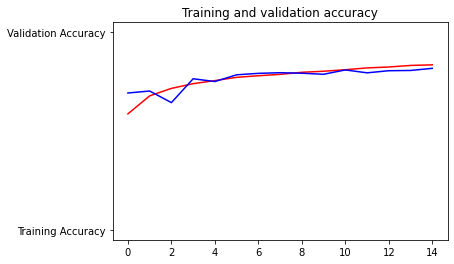

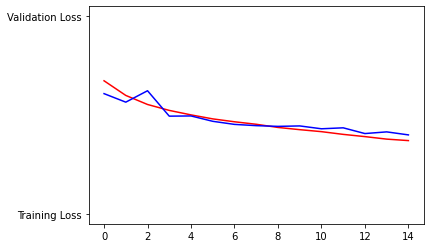

<Figure size 432x288 with 0 Axes>

In [13]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [13]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 1.jpg to 1.jpg
Saving 6.jpg to 6.jpg
Saving 12498.jpg to 12498.jpg
Saving 12500.jpg to 12500.jpg
[1.]
1.jpg is a dog
[1.]
6.jpg is a dog
[1.]
12498.jpg is a dog
[0.]
12500.jpg is a cat


In [14]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

In [0]:
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    batch_size=250,
    class_mode='binary'
)

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    batch_size=250,
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=90,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=6
)

Epoch 1/15
83/90 [==========================>...] - ETA: 4s - loss: 0.6683 - acc: 0.5841

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 69s 767ms/step - loss: 0.6666 - acc: 0.5869 - val_loss: 0.6253 - val_acc: 0.6773
Epoch 2/15
90/90 [==============================] - 67s 748ms/step - loss: 0.6083 - acc: 0.6685 - val_loss: 0.5701 - val_acc: 0.7167
Epoch 3/15
90/90 [==============================] - 67s 748ms/step - loss: 0.5610 - acc: 0.7127 - val_loss: 0.5573 - val_acc: 0.7020
Epoch 4/15
90/90 [==============================] - 68s 754ms/step - loss: 0.5272 - acc: 0.7337 - val_loss: 0.4900 - val_acc: 0.7640
Epoch 5/15
90/90 [==============================] - 68s 752ms/step - loss: 0.4985 - acc: 0.7570 - val_loss: 0.5285 - val_acc: 0.7260
Epoch 6/15
90/90 [==============================] - 68s 753ms/step - loss: 0.4767 - acc: 0.7704 - val_loss: 0.4956 - val_acc: 0.7520
Epoch 7/15
90/90 [==============================] - 68s 754ms/step - loss: 0.4615 - acc: 0.7807 - val_loss: 0.4568 - val_acc: 0.7840
Epoch 8/15
90/90 [==============================] - 68s 756ms/step - loss: 0.444

<Figure size 432x288 with 0 Axes>

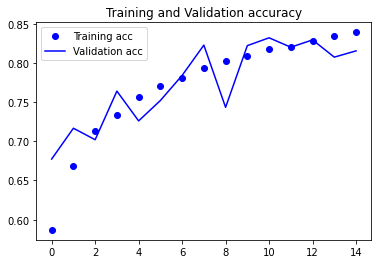

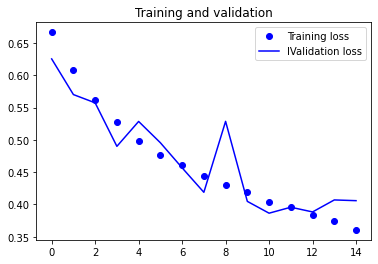

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =range(len(acc))

plt.plot(epochs, acc, 'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss,'bo',label='Training loss')
plt.plot(epochs,val_loss, 'b',label='lValidation loss')
plt.title('Training and validation')
plt.legend()
plt.figure()

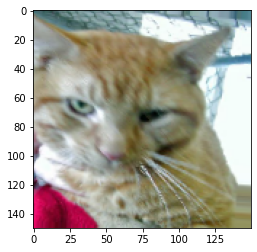

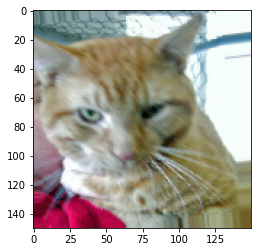

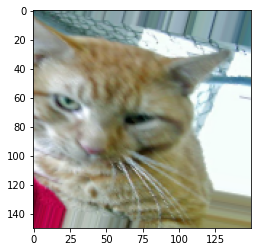

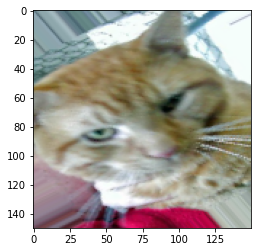

In [27]:
#USING AUGMENTATION
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

fnames = [os.path.join(TRAINING_CATS_DIR, fname) for fname in os.listdir(TRAINING_CATS_DIR)]

# We pick one image to "augment"
img_path = fnames[300]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [28]:
#Use model with data augmentation and drop out
model = models.Sequential()
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)      

In [36]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#Note that the validation data should note be augmented!
validation_datagen= ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    batch_size=250,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    batch_size=250,
    class_mode='binary')

history = model.fit(train_generator,
                    steps_per_epoch=90,
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps=6)


Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Epoch 1/15
35/90 [==========>...................] - ETA: 1:34 - loss: 0.6888 - acc: 0.5337

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 163s 2s/step - loss: 0.6772 - acc: 0.5595 - val_loss: 0.6559 - val_acc: 0.5680
Epoch 2/15
90/90 [==============================] - 163s 2s/step - loss: 0.6381 - acc: 0.6255 - val_loss: 0.6583 - val_acc: 0.6087
Epoch 3/15
90/90 [==============================] - 165s 2s/step - loss: 0.6140 - acc: 0.6583 - val_loss: 0.6255 - val_acc: 0.6353
Epoch 4/15
90/90 [==============================] - 161s 2s/step - loss: 0.6035 - acc: 0.6692 - val_loss: 0.6579 - val_acc: 0.6360
Epoch 5/15
90/90 [==============================] - 160s 2s/step - loss: 0.5881 - acc: 0.6805 - val_loss: 0.5795 - val_acc: 0.6927
Epoch 6/15
90/90 [==============================] - 160s 2s/step - loss: 0.5767 - acc: 0.6914 - val_loss: 0.5877 - val_acc: 0.6953
Epoch 7/15
90/90 [==============================] - 160s 2s/step - loss: 0.5651 - acc: 0.7047 - val_loss: 0.5155 - val_acc: 0.7520
Epoch 8/15
90/90 [==============================] - 160s 2s/step - loss: 0.5603 - acc: 0.7082 

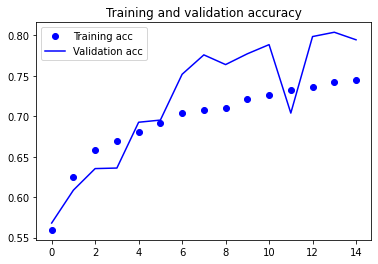

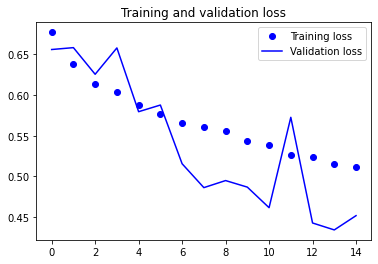

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
#USING A PRETRAINED CONVNET
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [42]:
import numpy as np
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(TRAINING_DIR, 2000)
validation_features, validation_labels = extract_features(VALIDATION_DIR, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
print(len(train_features), len(validation_features))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
2000 1000


In [44]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 0s 5ms/step - loss: 0.6105 - acc: 0.6610 - val_loss: 0.4465 - val_acc: 0.8370
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4368 - acc: 0.8000 - val_loss: 0.3783 - val_acc: 0.8460
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3749 - acc: 0.8375 - val_loss: 0.3314 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3382 - acc: 0.8555 - val_loss: 0.3053 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3055 - acc: 0.8735 - val_loss: 0.2901 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2832 - acc: 0.8870 - val_loss: 0.2791 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2629 - acc: 0.8930 - val_loss: 0.2757 - val_acc: 0.8770
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

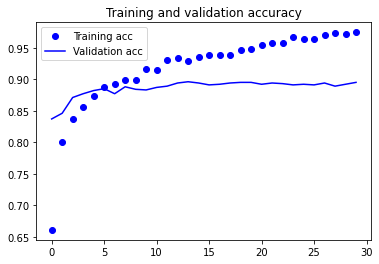

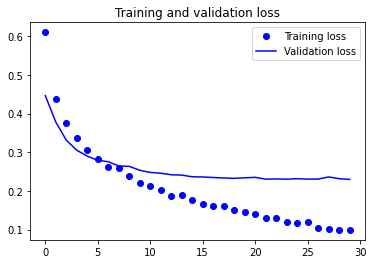

In [45]:
#import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
#Use COnvbase, with data augmentation
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [55]:
print(f'This is the no. of trainable weights before freezing conv_base:'
 f'{len(model.trainable_weights)}')

This is the no. of trainable weights before freezing conv_base:4


In [56]:
conv_base.trainable = False
print(f'No of trainable after freezing conv_base:\
{len(model.trainable_weights)}')

No of trainable after freezing conv_base:4


In [60]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        TRAINING_DIR,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=250,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=250,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=90,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 - 177s - loss: 0.3342 - acc: 0.8523 - val_loss: 0.2453 - val_acc: 0.8964
Epoch 2/10
90/90 - 177s - loss: 0.3258 - acc: 0.8580 - val_loss: 0.2440 - val_acc: 0.8980
Epoch 3/10
90/90 - 176s - loss: 0.3164 - acc: 0.8625 - val_loss: 0.2365 - val_acc: 0.9020
Epoch 4/10
90/90 - 173s - loss: 0.3171 - acc: 0.8617 - val_loss: 0.2321 - val_acc: 0.9020
Epoch 5/10
90/90 - 173s - loss: 0.3125 - acc: 0.8626 - val_loss: 0.2292 - val_acc: 0.9048
Epoch 6/10
90/90 - 173s - loss: 0.3096 - acc: 0.8628 - val_loss: 0.2271 - val_acc: 0.9076
Epoch 7/10
90/90 - 173s - loss: 0.3063 - acc: 0.8668 - val_loss: 0.2321 - val_acc: 0.9072
Epoch 8/10
90/90 - 172s - loss: 0.3067 - acc: 0.8672 - val_loss: 0.2288 - val_acc: 0.9080
Epoch 9/10
90/90 - 173s - loss: 0.3025 - acc: 0.8663 - val_loss: 0.2223 - val_acc: 0.9108
Epoch 10/10
90/90 - 173s - loss: 0.3001 - acc: 0.8684 - val_loss: 0.2205 - val_acc: 0.9096


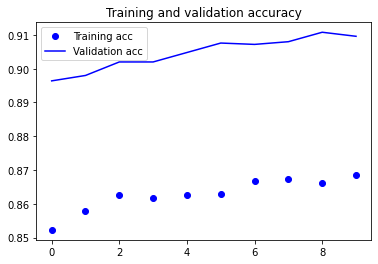

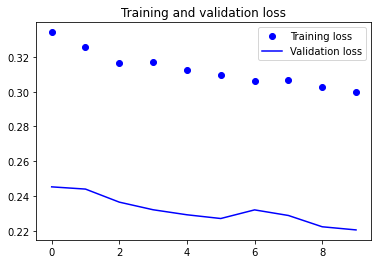

In [61]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
#Fine Tuning a pre-trained convnet
conv_base.trainable = True
##nake block 5 trainable, has specialised features, not generic.
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable =True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable =False

In [65]:
model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=90,
                    epochs=4,
                    validation_data=validation_generator,
                    validation_steps=10)

Epoch 1/4
25/90 [=======>......................] - ETA: 1:54 - loss: 0.3246 - acc: 0.8581

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 175s 2s/step - loss: 0.2959 - acc: 0.8715 - val_loss: 0.1915 - val_acc: 0.9220
Epoch 2/4
90/90 [==============================] - 174s 2s/step - loss: 0.2568 - acc: 0.8884 - val_loss: 0.1663 - val_acc: 0.9344
Epoch 3/4
90/90 [==============================] - 175s 2s/step - loss: 0.2320 - acc: 0.9016 - val_loss: 0.1557 - val_acc: 0.9360
Epoch 4/4
90/90 [==============================] - 175s 2s/step - loss: 0.2126 - acc: 0.9092 - val_loss: 0.1443 - val_acc: 0.9440


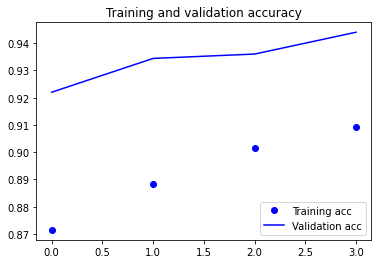

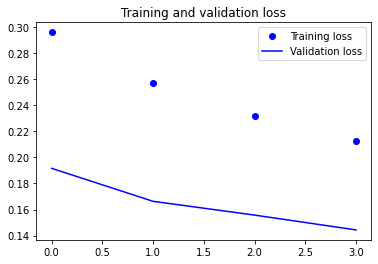

In [66]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()